<center><h1>DETEKCIJA NAPADA U OKVIRU SCADA SISTEMA</h1></center>

U okviru nastavka ovog dokumenta prolazicemo kroz samu analizu rada sistema kao i kroz samu detekciju napada.

<h3>Navigacija</h3>

- [Packages](#lib)
- [Dataset](#data)
- [Rad Sistema](#rad)
- [Decision tree](#tree)
- [Random forest algorithm](#random)
- [Random forest u praksi](#rfp)


<h3 id="lib">Packages</h3>

Neke od danasnjih najpopularnijih biblioteka su koriscene i prilikom ovog istrazivanja.
<li><a href="https://pandas.pydata.org/">pandas</a> Veoma efikasno rukovanje csv fajlovima</li>
<li><a href="https://matplotlib.org/">matplotlib</a> Vizuelizacija podataka</li>
<li><a href="https://xgboost.readthedocs.io/en/stable/">XGBoost</a> Extreme Gradient Boosting</li>
<li><a href="https://numpy.org/">Numpy</a> Pogodan za efikasnan rad sa nizovima podataka</li>
<li><a href="https://scikit-learn.org/stable/">SCKIT-LEARN</a> Open source library za machine learning</li>


In [5]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from radSistema import *
from IPython.display import Image
import numpy as np
import sklearn 

<h3 id="data">Dataset</h3>

U okviru ovog dela dokumenta izvrsicemo samo upoznavanje sa nasim podacima.

In [3]:
pdDf = pd.read_csv('learningDataNew.csv')
pd.set_option('expand_frame_repr', False)
print(f"Broj vrsta u okviru naseg dataset-a je:{pdDf.shape[0]}.")
print(f"Broj kolona u okviru naseg dataset-a je:{pdDf.shape[1]}.")
print(pdDf.head())

Broj vrsta u okviru naseg dataset-a je:239.
Broj kolona u okviru naseg dataset-a je:9.
   WT_VALUE01  WT_VALUE02  WT_VALUE03  CR_VALUE01  CR_VALUE02  CR_VALUE03  REPLAY_ATTACK  COMMAND_INJECTION  NORMAL_STATE
0         248         253         259           0           0           0              0                  0             1
1         230         226         223           1           0           0              0                  0             1
2         220         220         221           0           0           0              0                  0             1
3         226         230         235           0           0           0              0                  0             1
4         247         253         259           0           0           0              0                  0             1


Svaka kolona predstavlja nesto specificno u okviru dataset-a,tako je <b>WT skarenica za Water Thermometer</b>,dok je <b>CR skracenica za Control Rods</b>.<br>
Iz samog zaglavlja mozemo zakljuciti da smo belezili 3 uzastopne vrednosti WT kao i CR i nakon toga belezili da li su te vrednosti zabelezene u diskretnom trenutku prilikom normalnog rada sistema ili nekog napada.<br>
Ukoliko je u okviru kolone NORMAL_STATE upisana jedinica znaci da je sekvenca od 3 podatka zabelezena kada je sistem bio u normalnom stanju rada bez smetnji.<br>
Iz ovoga zakljucujemo da ukoliko su jedinice upisane u okviru kolona gde se nalaze REPLAY_ATTACK i COMMAND_INJECTION sekvenca podataka je bila zabelezena prilikom tih napada.<br>
<b>Zaglavlje:</b>

In [4]:
zaglavlje = ""
zaglavlje += " ".join(pdDf.head(0).columns)
# Print the result
print(zaglavlje)

WT_VALUE01 WT_VALUE02 WT_VALUE03 CR_VALUE01 CR_VALUE02 CR_VALUE03 REPLAY_ATTACK COMMAND_INJECTION NORMAL_STATE


<h3 id="rad">Rad sistema</h3>

U nastavku ce biti prikazan dijagram rada sistema u sva 3 slucaja.<br>
U okviru ovoga smo posmatrali samo Wather Thermometer koji moze da nam indikuje na to da su dosle neke nepravilnosti posto on sam predstavlja analognu vrednost<br>dok su Control Rods diskretna vrednost 1 ili 0 u zavisnosti da li su <b>spusteni(1)</b> ili <b>nisu spusteni(0).</b><br>
Za svrhu prikazivanja rada sistema koristicemo pomocnu f-ju koja se nalazi u radSistema.py

<h3>Normalan rad sistema</h3>

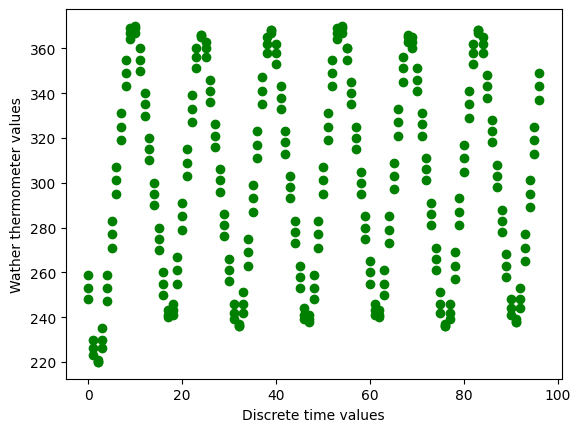

In [5]:
makePairsForPlot(pdDf)

<h3>Rad sistema prilikom replay attack-a</h3>

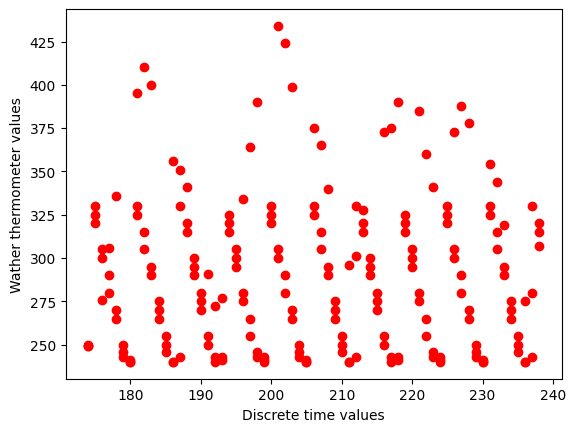

In [6]:
makePairsForPlot(pdDf,state="REPLAY_ATTACK",dot_color="red")

<h3>Rad sistema prilikom command injectiona</h3>

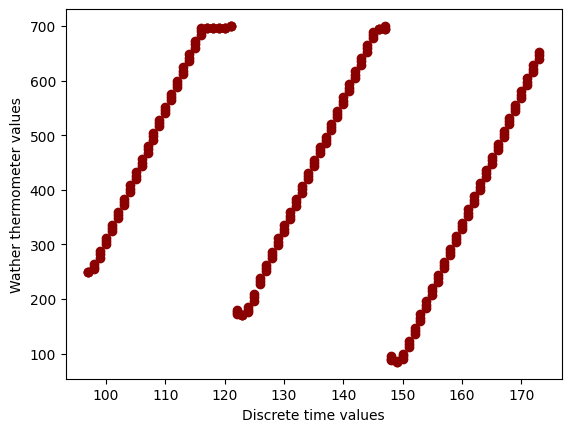

In [7]:
makePairsForPlot(pdDf,state="COMMAND_INJECTION",dot_color="darkred")

<h3 id="tree">Decision tree</h3>

U okviru ovog dela dokumenta cemo se upoznati sa samom logikom rada decision tree-a posto je sama implementacija banalna,medjutim da ne bi koristili machine learning modele kao black box modele dobro je znati sta se to zapravo odvija u pozadini i kakve nam sve mogucnosti daje.

<h5>Measuring purity</h5>


Decision tree koristi f-ju entropije kako bi izmerio "cistocu" odnosno "necistocu" dataset-a na sta se to odnosi videcemo u dole konkretnim primerima.

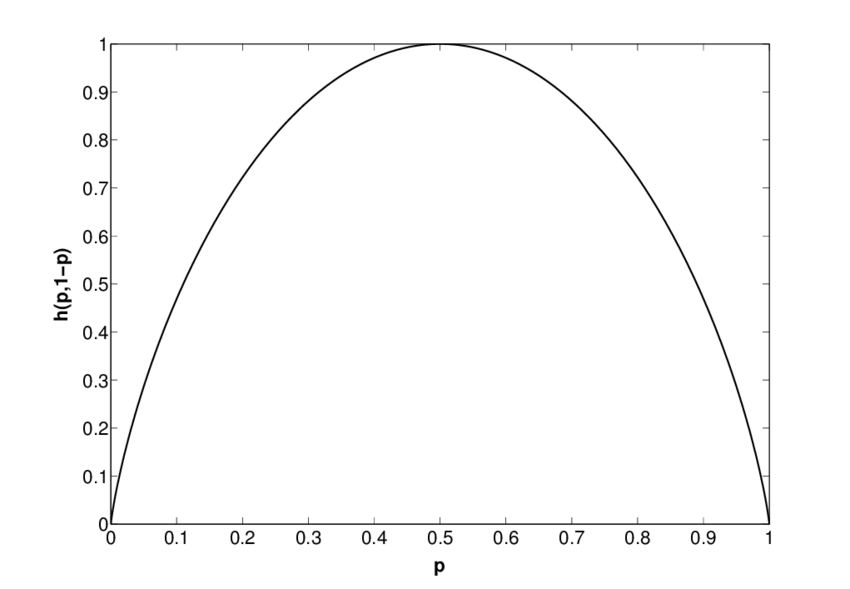

In [2]:
image_path = 'entropy.png'
display(Image(filename=image_path))

Sa same slike ne mozemo nista posebno da zakljucimo dok ne uvedemo konkretne primere.<br>
Najvaznije je napomenuti da kada nam je p = 0.5 "necistoca" dataset-a maksimalna == 1 <br>
p = 0 => "necistoca" dataset-a == 0 
p = 1 => "necistoca" dataset-a == 0 

Primer 1:


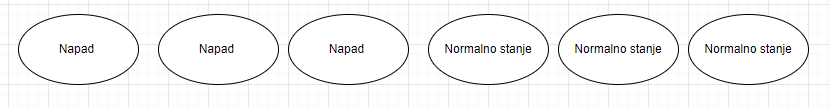

In [6]:
image_path01 = 'example01.png'
print("Primer 1:")
display(Image(filename=image_path01))


Posmatrajmo primer iznad gde vidimo da imamo 3 podatka koji su napadi isto tako 3 podatka koji su normalno stanje.<br>
Mi merimo necistocu dataset-a po tome koliko imamo napada,dakle u nasem slucaju <b>p ce predstavljati deo primeraka koji su upravo napadi => p = 3/6</b><br>
Iz ovoga ako pogledamo sliku mozemo da zakljucimo da nam je "necistoca" dataset-a maksimalna == 1.

Primer 2:


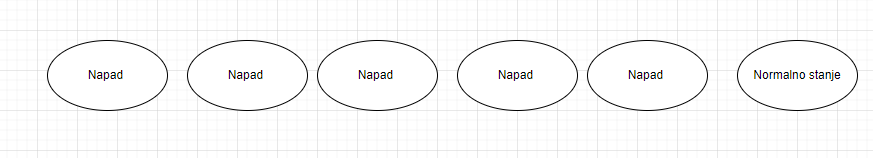

In [7]:
image_path02 = 'example02.png'
print("Primer 2:")
display(Image(filename=image_path02))

U primeru broj 2 mozemo da vidimo da imamo 5 napada => p = 5/6  => "necistoca" dataset-a 0.65

Ovo nam je vrlo vazno da znamo posto samo splitovanje podataka koje ce nas decision tree odraditi u pozadini se zasniva na ovom konceptu koji ce biti prikazan na slici ispod.

Primer 3:


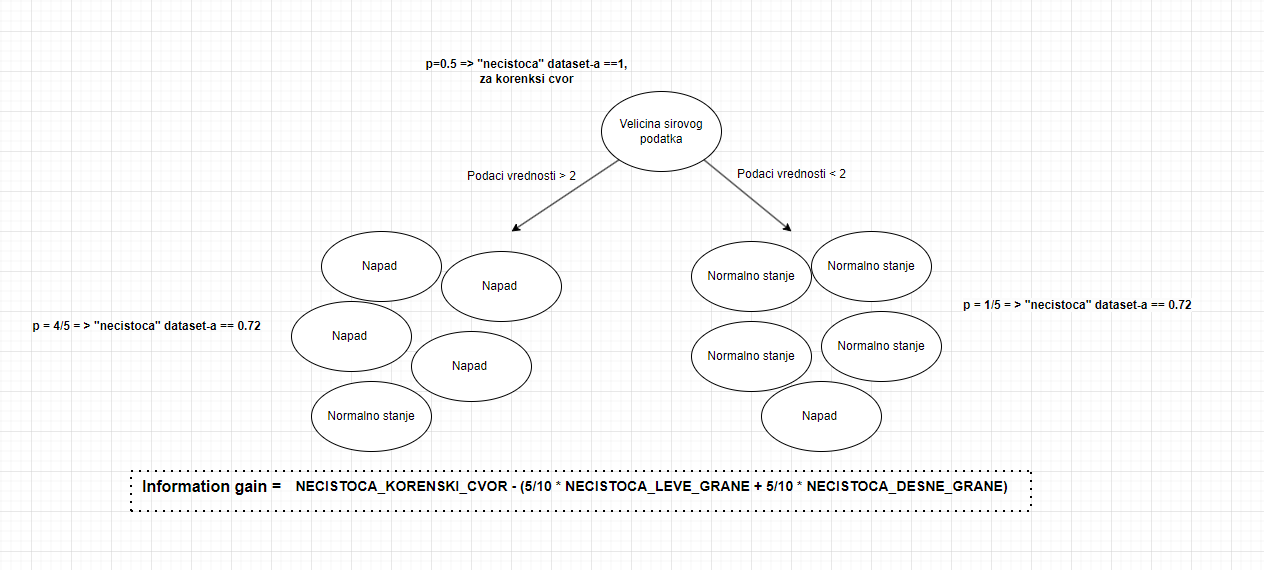

In [8]:
image_path03 = 'example03.png'
print("Primer 3:")
display(Image(filename=image_path03))

Na slici iznad vidimo jedan prost korak splitovanja podatak koji iskarikiran,sto bi znacilo da ne mora da znaci da nas model vrsi ovakvo splitovanje.<br>
Na primeru sa slike mi zelimo da dodjemo do rezonovanja sta je napad on nasih podataka.<br>
Na pocetku krecemo sa 10 podataka od cega su 5 napadi dok 5 nisu iz toga sledi da je za korenski cvor p=5/10 tj 0.5 i sama necistoca je 1 kad bi pogledali na sliku f-je iznad.<br>
Splitovanje smo vrsili tako sto smo gledali velicinu podatka dakle ako je nas podatak > 2 on bi zavrsio u levom delu stabla u suprotnom bi zavrsio u desno.<br>
Nakon ovoga ponavljamo postupak za levi i desni deo stabla.<br>
Kada smo odradili ovaj postupak za levi i desni deo racunamo <b>INFORMATION GAIN</b> on nam je jako bitan zato sto na osnovu njega znamo da li ima svrhe da se nase stablo prosiruje<br>
i da vrsi dalje splitovanje tih podataka.<br>
Ako bi on bio mali reda 0.03 sto cemo videti u sledecem primeru koji nije vezan za konkretno ovaj problem mi nemamo razloga da dalje vrsimo splitovanje podataka i tu se zaustavljamo.<br>
Kada bi ubacili ove nase vrednosti dobili bi smo 0.28 sto bi znacilo da imamo razloga da dalje splitujemo.<br>
Koeficient 5/10 ili ti 0.5 koji stoji uz "necistocu" leve i desne grane je dobijen tako sto smo videli koliko je podataka od samog korenskog cvora zavrsilo u levom a koliko u desnom delu.<br>

Primer 4:


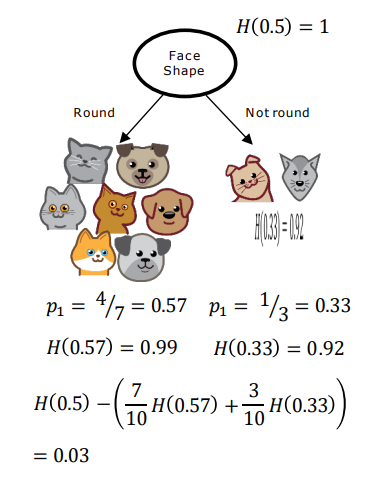

In [10]:
image_path04 = 'example04.png'
print("Primer 4:")
display(Image(filename=image_path04))

<h5>Do kada ponavljamo ovaj proces?<h5>
<li>Dok ne dodjemo do toga da je jedan cvor 100% jedna klasa.</li>
<li>Ako smo trenutnim splitovanjem dosli do maksimalne dubine stabla.</li>
<li>Ako je information gain manji od thresholda</li>
<li>Ako je broj podataka manji od thresholda</li>

<h3 id="random">Radom forest algorithm</h3>

Sam decision tree kao tehnika masinskog ucenja je veoma mocna ali njegovo prosirenje omogucava mnogo bolje nacine da vrsimo predvidjanja.<br>
U kombinaciji sa XGBoost-om nam daje veoma dobar algoritam koji dosta brze zakljucuje u odnosu na neuronsku mrezu,naravno kada govorimo o struktuiranim podacima.<br>
Mreza se dosta bolje ponasa prilikom obrade i zakljucivanja kod podataka koji nisu struktuirani kao sto su slike,audio,video...


<b>Pseudokod</b><br>
Imamo dataset na pocetku od kog cemo da formiramo decision tree.<br>
<b>for b=1 to B:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;U okviru petlje se korisisti sample and replacement proces kako bi se kreiralo novo stablo 
</b><br><br>
B - predstavlja broj decision tree-a koji zelimo da napravimo <br>
<b>Sample and replacement</b> - U svakoj iteraciji se vrsi formiranje novog decision tree-a.<br>
Ovaj proces mozemo da zamislimo kao da smo sve nase podatke stavili u jedan veliki dzak i u svakoj iteraciji prilikom kreiranja novog stabla<br>
vrsimo vadjenje odredjenog broja podataka kako bi formirali stablo sa tim sto kada neki podatak iskoristimo u formiranju nekog stabla u odredjenoj iteraciji<br>
taj podatak dobija odredjenu tezinu(weight) kako bi i drugi podaci dobili prednost prilikom formiranja sledeceg stabla.<br>
<b>Svakako postoji mogucnost da se neki podatak nadje u nekom stablu 2 puta.</b><br>
Jos jedna od brojnih prednosti XGBoost-a je ta sto od vise kreiranih stabala mozemo da kreiramo novo stablo tako sto spajamo prethodna i tako dolazimo do potencijalno najbolje predikcije.




<h3 id="rfp">Random forest u praksi</h3>
U okviru ovog dela dokumenta procicemo kroz samo koriscenje xgboost-a.<br>
Prvo sto treba da uradimo je da ucitamo podatke na kojima cemo trenirati nas tree.

In [9]:
boost = np.loadtxt("learningDataNew.csv",delimiter=',',skiprows=1) #preskacemo prvu vrstu zato sto nam je to header


X = boost[: , 0:6] #prvih 6 kolona su nam zapravo input 
Y = boost[: , 6:9] #poslednje 3 kolone su targeti 

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.35,random_state=39) 

model = xgb.XGBClassifier(random_state=42, max_depth=9, tree_method="hist", multi_strategy="multi_output_tree",n_estimators=100,nthread=5,learning_rate=0.32)
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.32, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy='multi_output_tree', n_estimators=100, n_jobs=None,
              nthread=5, num_parallel_tree=None, ...)


<h6>TRAIN_TEST_SPLIT</h6>
Velicina testnog skupa je preporucljiva da bude izmedju <b>0.2-0.35</b>,ako bi testni skup bio previse mali model bi se na oko cinio dobar(npr test_size=0.1),<br>
ali kada bi dobio nove podatke skroz bi se izgubio(ne bi znao model dobro da prediktuje).<br>
<b>random_state -</b>Definise nacin na koji ce se vrsiti podela samog dataset-a ako nismo definisali uvek ce drugacija podela biti izvrsena,<br><b>dok ako stavimo neki celobrojni podatak uvek ce se vrsiti ista podela.</b><br>
Ekseprimentalno prilikom razvoja modela 39 se pokazala kao najbolja odluka.
<h6>Kreiranje modela</h6>
<b>Random state-</b>radi na slicnom principu kao i kod train test splita samo se ne formira skup za treniranje nego decions trees,isto je ekesperimentalno utvrdjeno da je 42 najbolja opcija.<br>
<b>MAX_DEPTH -</b>definse maksimalnu dubinu stabla kako bi se sprecio overfiting,ako mi ne definisemo po defaultu je max_depth = 10<br>
Eksperimentalno dosli smo do zakljucka da dubina 9 daje najbolji model 84+ % tacnosti,dok dubina 6 daje 82+ %.<br>
Postavlja se pitanje da li uzeti vece stablo sa vecom tacnoscu ili je ipak bolje uzeti manje stablo gde brze dolazimo do odluke.<br>
Odgovor lezi u tome da u sistemima koji su uceni na vecoj kolicini podataka 2% nam ne znace preterano ako dolazimo brze do odluke.<br>
Za nas sistem smo koristili vece stablo posto je sistem ucen na maloj kolicini podataka i svakako nam model dosta brzo odlucuje,jednostavno smo hteli vecu preciznost.<br>
<b>TREE_METHOD -</b>Sa ovim definisemo nacin optimizacije formiranja novih stabala.<br>
Kada smo ovom parametru dodeli hist on ce koristiti greedy algorithm kako bi brze formirao nova stabla na osnovu istorije vec kreiranih.<br>
<b>MULTI_STRATEGY -</b>Ovaj parametar se koristi u kombinaciji sa three_method="hist" (preporuceno je)<br>
Govori da ce broj listova biti jedna sa brojem outputa koji treba da se prediktuje.<br>
<b>N_ESTIMATORS -</b>Zapravo govori koliko ce biti B iz pseudokoda.Eksperimentalno se 100 pokazalo kao najbolje.<br>
<b>NTHREAD -</b>Koliko ce tredova da vrsi tu obradu.Eksperimentalno se 5 pokazalo kao najbolje.<br>
<b>LEARNING_RATE -</b>Koliko ce brzo da uci model posto ipak sam naziv je EXTREME GRADIENT BOOST(skracenica od xgboost).Eksperimentalno se 0.32 pokazalo kao najbolje.<br>




In [12]:
model.fit(X_train,y_train) #treniranje modela
pred = model.predict(X_test) #predikcija nad testnim podacima
print(pred)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0.

In [15]:
acc = sklearn.metrics.accuracy_score(y_test, pred) #racunanje preciznosti modela
print("Acc: %.2f%%" % (acc * 100.0))  
print(f'Mean squared error:{sklearn.metrics.mean_squared_error(y_test, pred)}') 

Acc: 84.52%
Mean squared error:0.09126984126984128


Kako ne bi svaki put vrsili ponovno treniranje ovako natreniran model sacuvacemo i kasnije samo ucitati za upotrebu.

In [16]:
model.save_model('xgbNew.json')

In [18]:
newModel = xgb.XGBClassifier()
newModel.load_model('xgbNew.json')
print(newModel)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [22]:
y_pred1 = model.predict(X_test)
y_pred2 = newModel.predict(X_test)

models_equal = (y_pred1 == y_pred2).all()

if models_equal:
    print("The predictions of Model 1 and Model 2 are equal.")


The predictions of Model 1 and Model 2 are equal.


Iz ovoga dolazimo do zakljucka da imamo 2 ista modela.